<a href="https://colab.research.google.com/github/seckinadali/hurricane-damage-detection/blob/main/hurricane_damage_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Damaged Buildings on Post-Hurricane Satellite Imagery

In this project, I'll work with a dataset of satellite imagery data to automate the detection of buildings damaged by a hurricane. These images were taken in the aftermath of Hurricane Harvey in 2017. The key objective is to build a binary classifier which can distinguish between damaged and undamaged buildings in post-hurricane satellite imagery.

The dataset has been taken from [IEEE Dataport](https://ieee-dataport.org/open-access/detecting-damaged-buildings-post-hurricane-satellite-imagery-based-customized) and modified to feature a small training set of fewer than 1000 images and a large test set of more that 10000 images.

## Getting the dataset

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown 1AiS-MiwSjGuGYcuD2fo_N4wgYEL1JbdK

Downloading...
From (original): https://drive.google.com/uc?id=1AiS-MiwSjGuGYcuD2fo_N4wgYEL1JbdK
From (redirected): https://drive.google.com/uc?id=1AiS-MiwSjGuGYcuD2fo_N4wgYEL1JbdK&confirm=t&uuid=b9e700b0-d4b8-4533-a4b6-94eeab36d32b
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:00<00:00, 74.2MB/s]


In [ ]:
!unzip -q hurricane_detector.zip

replace train_hurricane/no_damage/-95.638504_29.838933.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
ls -l

total 38748
-rw-r--r-- 1 root root 39662128 Aug 28 10:25 hurricane_detector.zip
drwxr-xr-x 1 root root     4096 Aug 29 13:22 sample_data/
drwxr-xr-x 4 root root     4096 Aug 31 12:58 test_hurricane/
drwxr-xr-x 4 root root     4096 Aug 31 12:58 train_hurricane/


In [ ]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage  [655 entries exceeds filelimit, not opening dir]
└── no_damage  [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [ ]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage  [5895 entries exceeds filelimit, not opening dir]
└── no_damage  [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


## Loading dependencies

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.15.0


## Functions to create dataset generators

In [ ]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions


In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


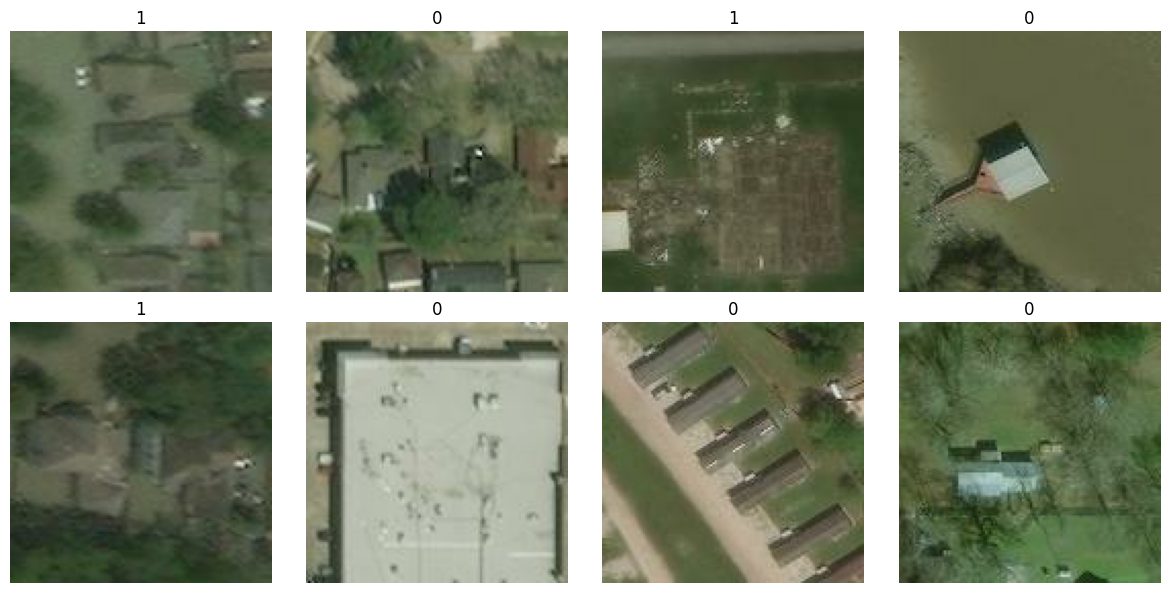

In [ ]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## Helper functions to display scores

In [ ]:
def train_metrics():
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.title('Accuracy During Training')
  plt.ylim([0.5, 1])
  plt.show()

In [ ]:
def test_metrics():
  print(classification_report(y_true, y_pred))
  sns.heatmap(
      pd.DataFrame(confusion_matrix(y_true, y_pred), index=classes, columns=classes),
      annot=True, cmap='Blues', fmt='d'
  )
  plt.title('Test Values (y-axis) vs Predictions (x-axis)')
  plt.show()

## Experiment 1: Baseline CNN

In [ ]:
# Model 1: Baseline CNN
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=IMG_SHAPE),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['Precision', 'Recall', 'accuracy']
)

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stop]
)

y_true, predictions = eval_model_on_test(model)
y_pred = (predictions > 0.5).astype(int)

Epoch 1/100
34/34 [==============================] - 16s 124ms/step - loss: 19.8730 - precision: 0.5928 - recall: 0.4331 - accuracy: 0.5777 - val_loss: 0.5565 - val_precision: 0.8438 - val_recall: 0.4355 - val_accuracy: 0.7048
Epoch 2/100
34/34 [==============================] - 1s 19ms/step - loss: 0.5016 - precision: 0.8265 - recall: 0.6817 - accuracy: 0.7746 - val_loss: 0.5236 - val_precision: 0.8120 - val_recall: 0.7661 - val_accuracy: 0.8118
Epoch 3/100
34/34 [==============================] - 1s 19ms/step - loss: 0.3818 - precision: 0.8496 - recall: 0.8192 - accuracy: 0.8408 - val_loss: 0.5205 - val_precision: 0.8707 - val_recall: 0.8145 - val_accuracy: 0.8598
Epoch 4/100
34/34 [==============================] - 1s 30ms/step - loss: 0.2625 - precision: 0.9026 - recall: 0.9077 - accuracy: 0.9071 - val_loss: 0.8262 - val_precision: 0.9118 - val_recall: 0.5000 - val_accuracy: 0.7491
Epoch 5/100
34/34 [==============================] - 1s 25ms/step - loss: 0.2434 - precision: 0.9187 

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   1%|          | 1/96 [00:00<00:52,  1.81it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:00<00:30,  3.10it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:00<00:23,  3.92it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:01<00:20,  4.53it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:01<00:18,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:01<00:16,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:01<00:14,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:01<00:14,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:01<00:14,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:02<00:14,  5.88it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:02<00:14,  5.77it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:02<00:13,  6.11it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:02<00:12,  6.45it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:02<00:12,  6.71it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:02<00:12,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:02<00:12,  6.22it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:03<00:12,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:03<00:11,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:03<00:11,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:03<00:11,  6.45it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:03<00:11,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:03<00:12,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:04<00:11,  6.13it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:04<00:11,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:04<00:11,  6.32it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:04<00:11,  6.25it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:04<00:10,  6.48it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:04<00:10,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:04<00:10,  6.66it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:05<00:09,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:05<00:09,  6.52it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:05<00:10,  6.37it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:05<00:09,  6.67it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:05<00:09,  6.32it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:05<00:09,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:06<00:09,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:06<00:09,  6.19it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:06<00:09,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:06<00:09,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:06<00:09,  6.01it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:06<00:09,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:07<00:08,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:07<00:08,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:07<00:07,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:07<00:07,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:07<00:08,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:07<00:08,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:07<00:07,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:08<00:07,  6.11it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:08<00:08,  5.74it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:08<00:08,  5.27it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:08<00:08,  5.04it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:09<00:08,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:09<00:08,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:09<00:08,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:09<00:08,  4.64it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:09<00:08,  4.52it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:10<00:08,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:10<00:08,  4.46it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:10<00:08,  4.39it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:10<00:07,  4.41it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:11<00:07,  4.57it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:11<00:06,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:11<00:06,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:11<00:05,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:11<00:05,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:11<00:04,  6.09it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:11<00:04,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:12<00:04,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:12<00:04,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:12<00:03,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:12<00:03,  6.61it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:12<00:03,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:12<00:03,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:13<00:03,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:13<00:03,  6.59it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:13<00:02,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:13<00:02,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:13<00:02,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:13<00:02,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:13<00:02,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:14<00:02,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:14<00:02,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:14<00:01,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:14<00:01,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:14<00:01,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:14<00:01,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:15<00:01,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:15<00:01,  6.71it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:15<00:00,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:15<00:00,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:15<00:00,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:15<00:00,  7.49it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:15<00:00,  7.46it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:15<00:00,  7.26it/s]

3/3 [==============================] - 0s 78ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:16<00:00,  5.85it/s]


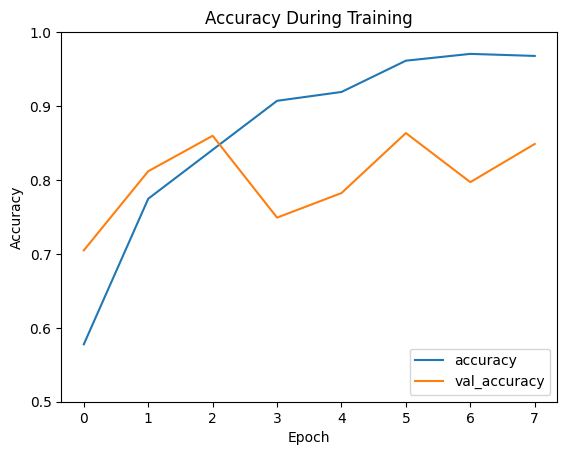

In [ ]:
train_metrics()

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      6333
           1       0.85      0.78      0.81      5895

    accuracy                           0.83     12228
   macro avg       0.83      0.82      0.82     12228
weighted avg       0.83      0.83      0.83     12228



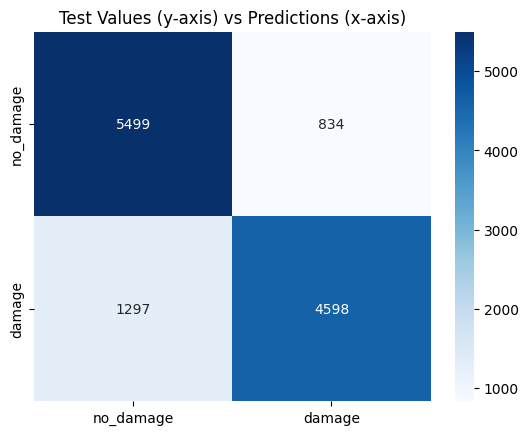

In [ ]:
test_metrics()

## Experiment 2: Data Augmentation

Here I'll tweak the previous model by adding the following:
- rotation
- contrast
- batch normalization (I'll drop dropout rate to 0.2)
- exponential decay learning rate scheduler

I tested other data augmentation techniques, including random flipping, zooming, and brightness adjustments, but these modifications led to performance metrics that were worse than the baseline. Similarly, different activation functions, such as leaky_relu and elu with the he_normal kernel initializer resulted in a decline in model performance.

In [ ]:
# Model 2: Tweaked CNN
model = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, input_shape=IMG_SHAPE),
  tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),

  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.5,
    staircase=True
)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['Precision', 'Recall', 'accuracy']
)

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stop]
)

y_true, predictions = eval_model_on_test(model)
y_pred = (predictions > 0.5).astype(int)

Epoch 1/100
34/34 [==============================] - 6s 36ms/step - loss: 1.4464 - precision: 0.7339 - recall: 0.7740 - accuracy: 0.7525 - val_loss: 1.1265 - val_precision: 0.7000 - val_recall: 0.3952 - val_accuracy: 0.6458
Epoch 2/100
34/34 [==============================] - 1s 21ms/step - loss: 0.5961 - precision: 0.8778 - recall: 0.8927 - accuracy: 0.8868 - val_loss: 0.6269 - val_precision: 0.5742 - val_recall: 0.9677 - val_accuracy: 0.6568
Epoch 3/100
34/34 [==============================] - 1s 19ms/step - loss: 0.4129 - precision: 0.9019 - recall: 0.9002 - accuracy: 0.9034 - val_loss: 0.7985 - val_precision: 0.5455 - val_recall: 0.8710 - val_accuracy: 0.6089
Epoch 4/100
34/34 [==============================] - 1s 18ms/step - loss: 0.2480 - precision: 0.9323 - recall: 0.9341 - accuracy: 0.9347 - val_loss: 2.6614 - val_precision: 0.5104 - val_recall: 0.9919 - val_accuracy: 0.5609
Epoch 5/100
34/34 [==============================] - 1s 20ms/step - loss: 0.1409 - precision: 0.9474 - r

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   1%|          | 1/96 [00:01<02:11,  1.39s/it]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:01<01:03,  1.49it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:01<00:40,  2.28it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:01<00:29,  3.08it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:02<00:24,  3.79it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:02<00:19,  4.53it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:02<00:17,  4.97it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:02<00:16,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:02<00:16,  5.27it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:02<00:15,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:02<00:13,  6.09it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:03<00:13,  6.11it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:03<00:13,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:03<00:12,  6.51it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:03<00:12,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:03<00:12,  6.58it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:03<00:11,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:04<00:12,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:04<00:12,  6.27it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:04<00:11,  6.57it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:04<00:11,  6.42it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:04<00:11,  6.62it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:04<00:11,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:04<00:11,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:05<00:10,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:05<00:10,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:05<00:10,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:05<00:10,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:05<00:10,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:05<00:11,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:06<00:10,  6.24it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:06<00:10,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:06<00:09,  6.50it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:06<00:11,  5.58it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:06<00:12,  5.06it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:07<00:12,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:07<00:12,  4.56it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:07<00:12,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:07<00:12,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:08<00:13,  4.29it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:08<00:12,  4.48it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:08<00:12,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:08<00:12,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:08<00:12,  4.29it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:09<00:10,  4.69it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:09<00:09,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:09<00:09,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:09<00:08,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:09<00:07,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:09<00:07,  6.11it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:10<00:07,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:10<00:07,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:10<00:07,  6.06it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:10<00:07,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:10<00:07,  5.85it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:10<00:06,  5.81it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:11<00:06,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:11<00:05,  6.40it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:11<00:05,  6.71it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:11<00:05,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:11<00:05,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:11<00:05,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:12<00:05,  6.28it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:12<00:05,  6.11it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:12<00:04,  6.34it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:12<00:04,  6.49it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:12<00:04,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:12<00:04,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:12<00:03,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:13<00:03,  6.61it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:13<00:03,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:13<00:03,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:13<00:03,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:13<00:03,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:13<00:03,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:14<00:03,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:14<00:02,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:14<00:02,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:14<00:02,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:14<00:02,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:14<00:02,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:14<00:02,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:15<00:01,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:15<00:01,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:15<00:01,  6.78it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:15<00:01,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:15<00:01,  7.01it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:15<00:01,  7.38it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:15<00:00,  7.45it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:16<00:00,  7.03it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:16<00:00,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:16<00:00,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:16<00:00,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:16<00:00,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:16<00:00,  6.80it/s]

3/3 [==============================] - 0s 5ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:17<00:00,  5.63it/s]


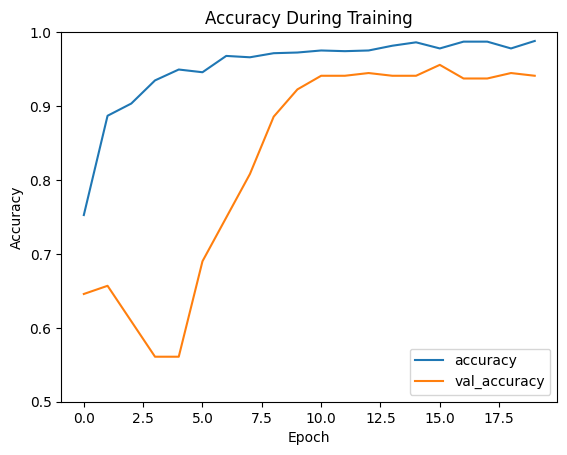

In [ ]:
train_metrics()

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      6333
           1       0.89      0.95      0.92      5895

    accuracy                           0.92     12228
   macro avg       0.92      0.92      0.92     12228
weighted avg       0.92      0.92      0.92     12228



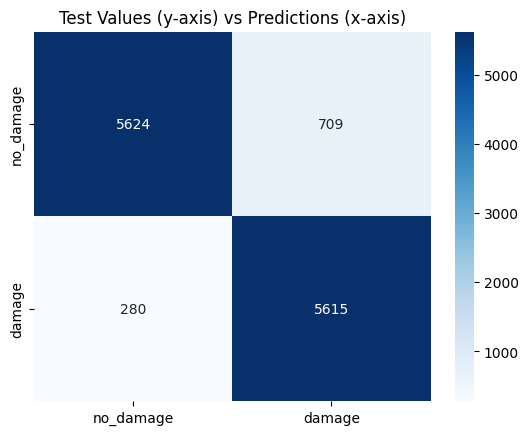

In [ ]:
test_metrics()

## Experiment 3: EfficientNet B0

Here I'll increase the patience of early stopping to 15 and consider a layer of size 512 before the final output.

In [ ]:
model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 128, 128, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 128, 128, 3)          0         ['normalization[0

In [ ]:
# points to last layer to ignore the top layer if the object instance include_top was set to True
last_conv_layer = model.get_layer('top_activation')

# will be used for all experiments from now on
conv_model = tf.keras.models.Model(inputs=model.input,
                   outputs=last_conv_layer.output)

# make sure all layers are frozen
conv_model.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, input_shape=IMG_SHAPE),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),

    conv_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.5,
    staircase=True
)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['Precision', 'Recall', 'accuracy']
)

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stop]
)

y_true, predictions = eval_model_on_test(model)
y_pred = (predictions > 0.5).astype(int)

Epoch 1/100
34/34 [==============================] - 14s 164ms/step - loss: 0.4077 - precision: 0.8111 - recall: 0.8004 - accuracy: 0.8114 - val_loss: 0.3509 - val_precision: 0.8750 - val_recall: 0.7339 - val_accuracy: 0.8303
Epoch 2/100
34/34 [==============================] - 1s 38ms/step - loss: 0.2410 - precision: 0.9291 - recall: 0.8889 - accuracy: 0.9126 - val_loss: 0.3125 - val_precision: 0.8870 - val_recall: 0.8226 - val_accuracy: 0.8708
Epoch 3/100
34/34 [==============================] - 1s 39ms/step - loss: 0.2260 - precision: 0.9171 - recall: 0.9171 - accuracy: 0.9190 - val_loss: 0.2834 - val_precision: 0.9027 - val_recall: 0.8226 - val_accuracy: 0.8782
Epoch 4/100
34/34 [==============================] - 1s 36ms/step - loss: 0.1798 - precision: 0.9254 - recall: 0.9341 - accuracy: 0.9310 - val_loss: 0.3038 - val_precision: 0.9065 - val_recall: 0.7823 - val_accuracy: 0.8635
Epoch 5/100
34/34 [==============================] - 2s 70ms/step - loss: 0.1451 - precision: 0.9502 -

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 2s 28ms/step


Predicting on Test Data:   1%|          | 1/96 [00:01<02:57,  1.87s/it]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:02<01:24,  1.11it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:02<00:56,  1.65it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:02<00:41,  2.22it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:02<00:34,  2.63it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:03<00:29,  3.09it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:03<00:25,  3.47it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:03<00:33,  2.63it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:04<00:28,  3.03it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:04<00:25,  3.41it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:04<00:23,  3.57it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:04<00:21,  3.86it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:04<00:20,  4.05it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:05<00:20,  3.96it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:05<00:20,  3.97it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:05<00:19,  4.07it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:05<00:20,  3.87it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:06<00:21,  3.65it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:06<00:22,  3.48it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:06<00:22,  3.40it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:07<00:22,  3.37it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:07<00:22,  3.25it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:07<00:23,  3.17it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:08<00:22,  3.16it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:08<00:21,  3.24it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:08<00:20,  3.43it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:08<00:18,  3.64it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:09<00:17,  3.92it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:09<00:16,  4.09it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:09<00:15,  4.25it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:09<00:14,  4.35it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:10<00:14,  4.46it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:10<00:14,  4.20it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:10<00:14,  4.33it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:10<00:13,  4.40it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:10<00:13,  4.36it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:11<00:14,  4.13it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:11<00:14,  4.09it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:11<00:13,  4.27it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:11<00:13,  4.11it/s]

4/4 [==============================] - 0s 21ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:12<00:13,  4.19it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:12<00:12,  4.34it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:12<00:12,  4.22it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:12<00:12,  4.11it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:13<00:12,  4.01it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:13<00:12,  4.01it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:13<00:12,  4.00it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:13<00:12,  3.92it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:14<00:11,  4.13it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:14<00:10,  4.23it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:14<00:10,  4.12it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:14<00:10,  4.30it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:15<00:10,  4.09it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:15<00:10,  4.04it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:15<00:09,  4.22it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:15<00:09,  4.15it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:16<00:09,  4.11it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:16<00:09,  3.93it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:16<00:09,  3.92it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:16<00:09,  3.94it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:17<00:08,  4.07it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:17<00:08,  4.19it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:17<00:07,  4.35it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:17<00:07,  4.49it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:18<00:07,  4.28it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:18<00:07,  4.18it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:18<00:07,  3.96it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:18<00:07,  3.74it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:19<00:07,  3.62it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:19<00:07,  3.57it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:19<00:07,  3.45it/s]

4/4 [==============================] - 0s 27ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:20<00:07,  3.35it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:20<00:07,  3.25it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:20<00:06,  3.35it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:20<00:06,  3.38it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:21<00:05,  3.35it/s]

4/4 [==============================] - 0s 27ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:21<00:05,  3.39it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:21<00:05,  3.50it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:22<00:04,  3.63it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:22<00:04,  3.91it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:22<00:03,  3.90it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:22<00:03,  4.10it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:23<00:03,  4.01it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:23<00:02,  4.17it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:23<00:02,  4.13it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:23<00:02,  4.16it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:23<00:02,  4.13it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:24<00:01,  4.36it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:24<00:01,  4.57it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:24<00:01,  4.70it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:24<00:01,  4.84it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:24<00:00,  4.51it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:25<00:00,  4.62it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:25<00:00,  4.49it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:25<00:00,  4.43it/s]

3/3 [==============================] - 2s 488ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:28<00:00,  3.38it/s]


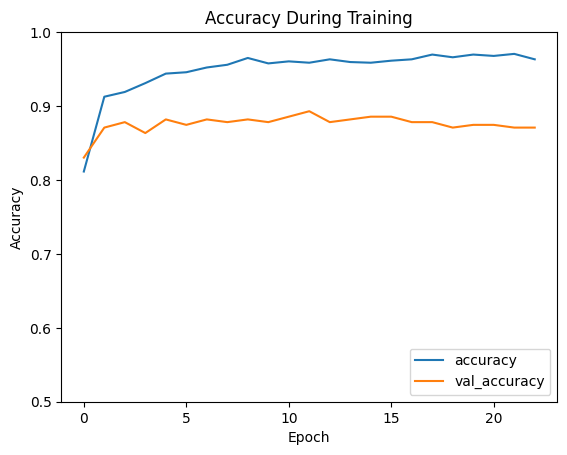

In [ ]:
train_metrics()

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6333
           1       0.94      0.88      0.91      5895

    accuracy                           0.91     12228
   macro avg       0.91      0.91      0.91     12228
weighted avg       0.91      0.91      0.91     12228



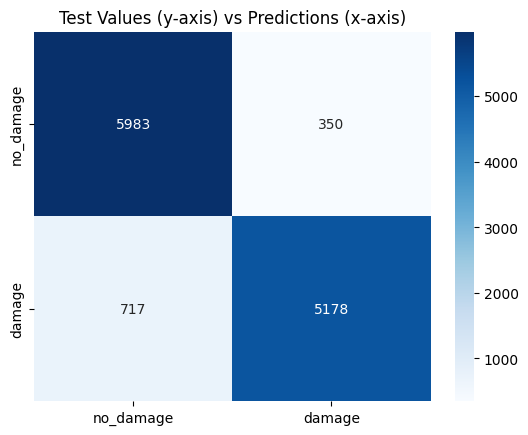

In [ ]:
test_metrics()

## Experiment 4: EfficientNet B0 last block unfrozen

In order to allow for better fine-tuning, I'll decrease inital learning rate to 1e-4.

In [ ]:
for i, layer in enumerate(conv_model.layers):
  print(i, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
conv_model.trainable = False

# unfreeze block 7
for layer in conv_model.layers[222:]:
  layer.trainable = True

In [ ]:
# check layer trainability
for i, layer in enumerate(conv_model.layers):
  print(i, layer.name, '-->', layer.trainable)

0 input_1 --> False
1 rescaling --> False
2 normalization --> False
3 rescaling_1 --> False
4 stem_conv_pad --> False
5 stem_conv --> False
6 stem_bn --> False
7 stem_activation --> False
8 block1a_dwconv --> False
9 block1a_bn --> False
10 block1a_activation --> False
11 block1a_se_squeeze --> False
12 block1a_se_reshape --> False
13 block1a_se_reduce --> False
14 block1a_se_expand --> False
15 block1a_se_excite --> False
16 block1a_project_conv --> False
17 block1a_project_bn --> False
18 block2a_expand_conv --> False
19 block2a_expand_bn --> False
20 block2a_expand_activation --> False
21 block2a_dwconv_pad --> False
22 block2a_dwconv --> False
23 block2a_bn --> False
24 block2a_activation --> False
25 block2a_se_squeeze --> False
26 block2a_se_reshape --> False
27 block2a_se_reduce --> False
28 block2a_se_expand --> False
29 block2a_se_excite --> False
30 block2a_project_conv --> False
31 block2a_project_bn --> False
32 block2b_expand_conv --> False
33 block2b_expand_bn --> False
3

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, input_shape=IMG_SHAPE),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),

    conv_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4, # smaller than before
    decay_steps=100,
    decay_rate=0.5,
    staircase=True
)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['Precision', 'Recall', 'accuracy']
)

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stop]
)

y_true, predictions = eval_model_on_test(model)
y_pred = (predictions > 0.5).astype(int)

Epoch 1/100
34/34 [==============================] - 11s 86ms/step - loss: 0.5971 - precision: 0.6772 - recall: 0.6836 - accuracy: 0.6863 - val_loss: 0.5501 - val_precision: 0.8904 - val_recall: 0.5242 - val_accuracy: 0.7528
Epoch 2/100
34/34 [==============================] - 1s 37ms/step - loss: 0.4592 - precision: 0.8578 - recall: 0.7495 - accuracy: 0.8169 - val_loss: 0.4920 - val_precision: 0.9091 - val_recall: 0.5645 - val_accuracy: 0.7749
Epoch 3/100
34/34 [==============================] - 1s 37ms/step - loss: 0.3688 - precision: 0.8726 - recall: 0.8512 - accuracy: 0.8666 - val_loss: 0.4526 - val_precision: 0.9048 - val_recall: 0.6129 - val_accuracy: 0.7934
Epoch 4/100
34/34 [==============================] - 1s 41ms/step - loss: 0.3646 - precision: 0.8778 - recall: 0.8249 - accuracy: 0.8583 - val_loss: 0.4337 - val_precision: 0.9205 - val_recall: 0.6532 - val_accuracy: 0.8155
Epoch 5/100
34/34 [==============================] - 1s 38ms/step - loss: 0.3207 - precision: 0.8834 - 

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 1s 29ms/step


Predicting on Test Data:   1%|          | 1/96 [00:02<03:19,  2.10s/it]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:02<01:35,  1.01s/it]

4/4 [==============================] - 0s 28ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:02<01:01,  1.50it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:02<00:46,  1.99it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:03<00:37,  2.41it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:03<00:30,  2.91it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:03<00:27,  3.20it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:03<00:24,  3.53it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:04<00:35,  2.44it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:04<00:30,  2.86it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:04<00:27,  3.12it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:05<00:25,  3.31it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:05<00:23,  3.57it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:05<00:21,  3.79it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:05<00:21,  3.80it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:06<00:21,  3.80it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:06<00:20,  3.78it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:06<00:20,  3.72it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:07<00:21,  3.54it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:07<00:22,  3.44it/s]

4/4 [==============================] - 0s 28ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:07<00:22,  3.32it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:08<00:22,  3.23it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:08<00:22,  3.22it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:08<00:23,  3.11it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:09<00:23,  3.05it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:09<00:22,  3.08it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:09<00:19,  3.48it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:09<00:18,  3.60it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:10<00:18,  3.65it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:10<00:17,  3.67it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:10<00:16,  3.97it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:10<00:16,  3.97it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:10<00:15,  4.15it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:11<00:14,  4.26it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:11<00:14,  4.15it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:11<00:14,  4.24it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:11<00:13,  4.38it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:12<00:12,  4.51it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:12<00:13,  4.32it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:12<00:12,  4.48it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:12<00:12,  4.52it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:13<00:12,  4.33it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:13<00:12,  4.39it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:13<00:12,  4.24it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:13<00:12,  4.16it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:13<00:11,  4.25it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:14<00:11,  4.40it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:14<00:11,  4.27it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:14<00:11,  4.15it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:14<00:10,  4.30it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:15<00:10,  4.15it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:15<00:10,  4.29it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:15<00:09,  4.36it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:15<00:10,  4.16it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:16<00:09,  4.12it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:16<00:09,  4.09it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:16<00:09,  3.91it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:16<00:09,  3.87it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:17<00:09,  4.07it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:17<00:09,  3.96it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:17<00:08,  4.06it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:17<00:08,  4.21it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:18<00:07,  4.13it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:18<00:07,  4.10it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:18<00:07,  4.29it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:18<00:06,  4.40it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:18<00:06,  4.53it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:19<00:06,  4.30it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:19<00:06,  4.00it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:19<00:06,  3.86it/s]

4/4 [==============================] - 0s 27ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:20<00:06,  3.66it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:20<00:06,  3.46it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:20<00:06,  3.44it/s]

4/4 [==============================] - 0s 28ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:21<00:06,  3.51it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:21<00:06,  3.32it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:21<00:06,  3.19it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:22<00:05,  3.20it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:22<00:05,  3.34it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:22<00:04,  3.68it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:22<00:04,  3.78it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:22<00:03,  3.85it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:23<00:03,  4.11it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:23<00:03,  4.08it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:23<00:02,  4.12it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:23<00:02,  4.23it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:24<00:02,  4.46it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:24<00:02,  4.40it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:24<00:01,  4.35it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:24<00:01,  4.51it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:24<00:01,  4.68it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:25<00:01,  4.87it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:25<00:00,  4.67it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:25<00:00,  4.83it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:25<00:00,  4.85it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:25<00:00,  4.68it/s]

3/3 [==============================] - 1s 21ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:40<00:00,  2.34it/s]


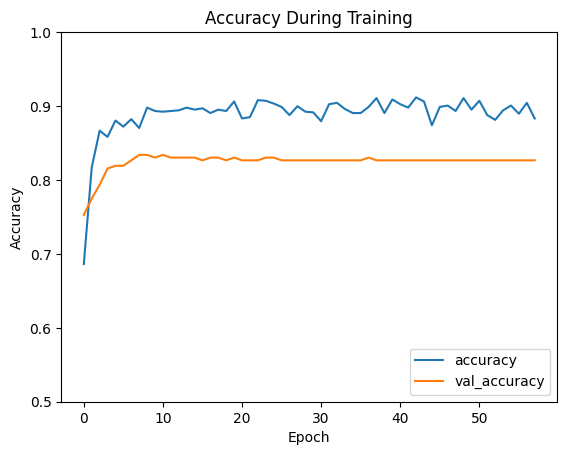

In [ ]:
train_metrics()

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      6333
           1       0.91      0.80      0.85      5895

    accuracy                           0.86     12228
   macro avg       0.87      0.86      0.86     12228
weighted avg       0.87      0.86      0.86     12228



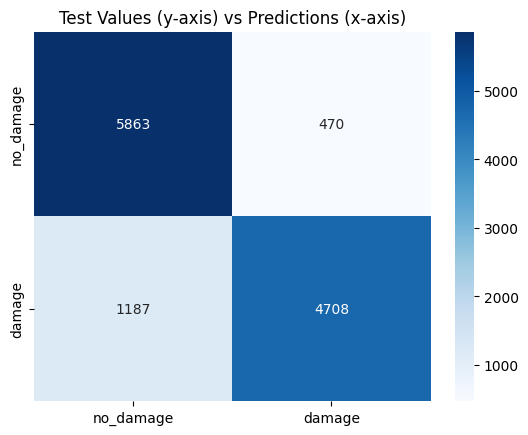

In [ ]:
test_metrics()

## Experiment 5: EfficientNet B0 last two blocks unfrozen

In [ ]:
for i, layer in enumerate(conv_model.layers):
  print(i, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
conv_model.trainable = False

# unfreeze block 7 and 6
for layer in conv_model.layers[163:]:
  layer.trainable = True

In [ ]:
# check layer trainability
for i, layer in enumerate(conv_model.layers):
  print(i, layer.name, '-->', layer.trainable)

0 input_1 --> False
1 rescaling --> False
2 normalization --> False
3 rescaling_1 --> False
4 stem_conv_pad --> False
5 stem_conv --> False
6 stem_bn --> False
7 stem_activation --> False
8 block1a_dwconv --> False
9 block1a_bn --> False
10 block1a_activation --> False
11 block1a_se_squeeze --> False
12 block1a_se_reshape --> False
13 block1a_se_reduce --> False
14 block1a_se_expand --> False
15 block1a_se_excite --> False
16 block1a_project_conv --> False
17 block1a_project_bn --> False
18 block2a_expand_conv --> False
19 block2a_expand_bn --> False
20 block2a_expand_activation --> False
21 block2a_dwconv_pad --> False
22 block2a_dwconv --> False
23 block2a_bn --> False
24 block2a_activation --> False
25 block2a_se_squeeze --> False
26 block2a_se_reshape --> False
27 block2a_se_reduce --> False
28 block2a_se_expand --> False
29 block2a_se_excite --> False
30 block2a_project_conv --> False
31 block2a_project_bn --> False
32 block2b_expand_conv --> False
33 block2b_expand_bn --> False
3

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, input_shape=IMG_SHAPE),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),

    conv_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4, # smaller than before
    decay_steps=100,
    decay_rate=0.5,
    staircase=True
)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['Precision', 'Recall', 'accuracy']
)

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stop]
)

y_true, predictions = eval_model_on_test(model)
y_pred = (predictions > 0.5).astype(int)

Epoch 1/100
34/34 [==============================] - 11s 87ms/step - loss: 0.6088 - precision: 0.7231 - recall: 0.5066 - accuracy: 0.6642 - val_loss: 0.5480 - val_precision: 0.8132 - val_recall: 0.5968 - val_accuracy: 0.7528
Epoch 2/100
34/34 [==============================] - 1s 38ms/step - loss: 0.4524 - precision: 0.8543 - recall: 0.7401 - accuracy: 0.8114 - val_loss: 0.4888 - val_precision: 0.8791 - val_recall: 0.6452 - val_accuracy: 0.7970
Epoch 3/100
34/34 [==============================] - 1s 38ms/step - loss: 0.3984 - precision: 0.8585 - recall: 0.8230 - accuracy: 0.8473 - val_loss: 0.4565 - val_precision: 0.8710 - val_recall: 0.6532 - val_accuracy: 0.7970
Epoch 4/100
34/34 [==============================] - 1s 43ms/step - loss: 0.3516 - precision: 0.8878 - recall: 0.8192 - accuracy: 0.8611 - val_loss: 0.4401 - val_precision: 0.8817 - val_recall: 0.6613 - val_accuracy: 0.8044
Epoch 5/100
34/34 [==============================] - 2s 46ms/step - loss: 0.3338 - precision: 0.9004 - 

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 1s 31ms/step


Predicting on Test Data:   1%|          | 1/96 [00:01<02:50,  1.80s/it]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:02<01:22,  1.14it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:02<00:53,  1.73it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:02<00:41,  2.23it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:02<00:33,  2.75it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:02<00:29,  3.07it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:03<00:25,  3.52it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:03<00:23,  3.81it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:03<00:21,  4.10it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:03<00:21,  4.03it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:04<00:19,  4.25it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:04<00:20,  4.15it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:04<00:19,  4.32it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:04<00:18,  4.42it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:04<00:18,  4.44it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:05<00:18,  4.26it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:05<00:17,  4.39it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:05<00:18,  4.22it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:05<00:17,  4.38it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:06<00:16,  4.51it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:06<00:16,  4.61it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:06<00:16,  4.39it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:06<00:16,  4.42it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:06<00:16,  4.45it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:07<00:15,  4.56it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:07<00:15,  4.54it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:07<00:16,  4.29it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:07<00:15,  4.38it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:08<00:14,  4.53it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:08<00:14,  4.64it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:08<00:14,  4.45it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:08<00:14,  4.53it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:08<00:13,  4.59it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:09<00:14,  4.31it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:09<00:14,  4.21it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:09<00:13,  4.31it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:09<00:14,  4.05it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:10<00:14,  4.05it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:10<00:14,  3.94it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:10<00:14,  3.75it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:11<00:15,  3.54it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:11<00:15,  3.46it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:11<00:15,  3.40it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:12<00:15,  3.27it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:12<00:15,  3.30it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:12<00:14,  3.47it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:12<00:12,  3.78it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:13<00:11,  4.06it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:13<00:11,  4.23it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:13<00:10,  4.40it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:13<00:10,  4.23it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:13<00:10,  4.12it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:14<00:10,  4.10it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:14<00:09,  4.30it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:14<00:09,  4.44it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:14<00:08,  4.53it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:15<00:08,  4.67it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:15<00:07,  4.76it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:15<00:07,  4.75it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:15<00:08,  4.41it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:15<00:07,  4.52it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:16<00:07,  4.60it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:16<00:07,  4.32it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:16<00:07,  4.49it/s]

4/4 [==============================] - 0s 21ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:16<00:06,  4.52it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:17<00:06,  4.67it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:17<00:06,  4.69it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:17<00:05,  4.77it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:17<00:05,  4.70it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:17<00:05,  4.69it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:18<00:05,  4.75it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:18<00:05,  4.80it/s]

4/4 [==============================] - 0s 22ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:18<00:05,  4.55it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:18<00:05,  4.39it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:19<00:04,  4.24it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:19<00:04,  4.13it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:19<00:04,  4.26it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:19<00:04,  4.15it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:20<00:04,  4.07it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:20<00:04,  3.98it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:20<00:03,  4.21it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:20<00:03,  4.31it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:20<00:03,  4.21it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:21<00:02,  4.37it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:21<00:02,  4.29it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:21<00:02,  4.35it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:21<00:02,  4.23it/s]

4/4 [==============================] - 0s 23ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:22<00:01,  4.20it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:22<00:01,  4.32it/s]

4/4 [==============================] - 0s 24ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:22<00:01,  4.38it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:22<00:01,  3.99it/s]

4/4 [==============================] - 0s 26ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:23<00:01,  3.87it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:23<00:00,  3.91it/s]

4/4 [==============================] - 0s 25ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:23<00:00,  4.07it/s]

4/4 [==============================] - 0s 27ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:23<00:00,  3.93it/s]

3/3 [==============================] - 2s 29ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:40<00:00,  2.34it/s]


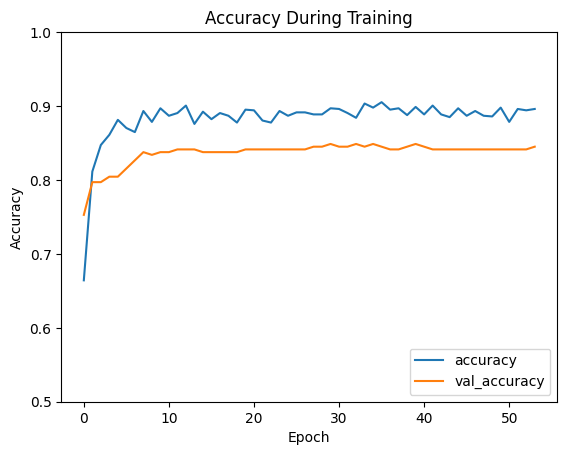

In [ ]:
train_metrics()

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      6333
           1       0.92      0.78      0.84      5895

    accuracy                           0.86     12228
   macro avg       0.87      0.86      0.86     12228
weighted avg       0.87      0.86      0.86     12228



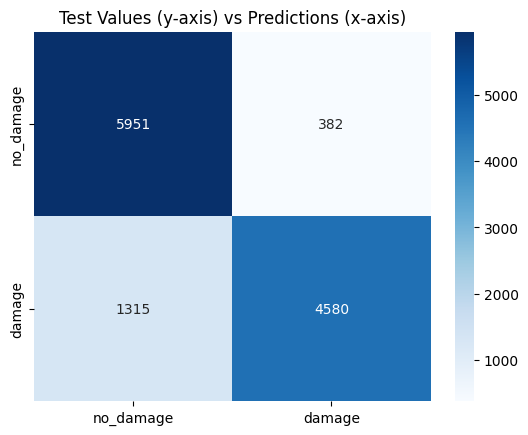

In [ ]:
test_metrics()